# Data Description
Master thesis of Nikolai Popov, MAE-2025

In [1]:
# Libraries import
import pandas as pd # dataframes
import numpy as np # for matrices/vectors
from tqdm import tqdm # for progress bar
import warnings # to supress warninings
warnings.simplefilter(action='ignore', category=Warning)
import matplotlib.pyplot as plt # for graphs
import seaborn as sns # for graphs
import geopandas as gpd # to modify data for QGIS analysis
from shapely.geometry import Point # to modify data for QGIS analysis

In [2]:
balanced_df = pd.read_csv("C:/Users/Popov/Documents/Research/Volchkova_thesis/Data/Cleaned_datasets/balanced_dataset_file_collab.csv", 
                          sep=",", on_bad_lines="skip", low_memory=False)
balanced_df.head(3)

,INN,Year,okveds,coord,Capital,Output,Post_d,Treated_d
0,245008247,2011,"['47.21', '47.22', '47.29', '49.4']","54.49938, 55.88891",85264000.0,65588000.0,0,0
1,245008247,2012,"['47.21', '47.22', '47.29', '49.4']","54.49938, 55.88891",100445000.0,60109000.0,0,0
2,245008247,2013,"['47.21', '47.22', '47.29', '49.4']","54.49938, 55.88891",119914000.0,57491000.0,0,0


## Descriptive statistics

In [3]:
# Convert to LaTeX
# Generate summary statistics
summary_stats = balanced_df[['Capital', 'Output', 'Treated_d']].describe()

# Rename the first row index ('count' -> 'Obs.')
summary_stats.rename(index={'count': 'Obs.'}, inplace=True)

# Convert to LaTeX with formatted output
latex_table = summary_stats.to_latex(
    float_format="%.2e", 
    caption="Summary Statistics", 
    label="tab:summary",
    column_format="lcccc"
)

# Save to a .tex file
output_dir = "C:/Users/Popov/Documents/Research/Volchkova_thesis/Output"
summary_stats_dir = f"{output_dir}/summary_stats.tex"

with open(summary_stats_dir, "w") as f:
    f.write(latex_table)

# # Print LaTeX output (optional)
print(latex_table)
summary_stats

\begin{table}
\caption{Summary Statistics}
\label{tab:summary}
\begin{tabular}{lcccc}
\toprule
 & Capital & Output & Treated_d \\
\midrule
Obs. & 6.40e+04 & 6.40e+04 & 6.40e+04 \\
mean & 2.04e+08 & 4.92e+08 & 7.49e-01 \\
std & 8.69e+08 & 2.59e+09 & 4.33e-01 \\
min & 1.00e+03 & 1.00e+03 & 0.00e+00 \\
25% & 9.59e+06 & 1.62e+07 & 0.00e+00 \\
50% & 4.25e+07 & 7.10e+07 & 1.00e+00 \\
75% & 1.31e+08 & 2.53e+08 & 1.00e+00 \\
max & 4.58e+10 & 1.41e+11 & 1.00e+00 \\
\bottomrule
\end{tabular}
\end{table}



,Capital,Output,Treated_d
Obs.,6.398700e+04,6.398700e+04,63987.000000
mean,2.036584e+08,4.924126e+08,0.749371
std,8.691546e+08,2.585171e+09,0.433379
min,1.000000e+03,1.000000e+03,0.000000
25%,9.589000e+06,1.617400e+07,0.000000
50%,4.253600e+07,7.096200e+07,1.000000
75%,1.305825e+08,2.527260e+08,1.000000
max,4.581020e+10,1.411090e+11,1.000000


## Distributions

### Capital

For log of capital:

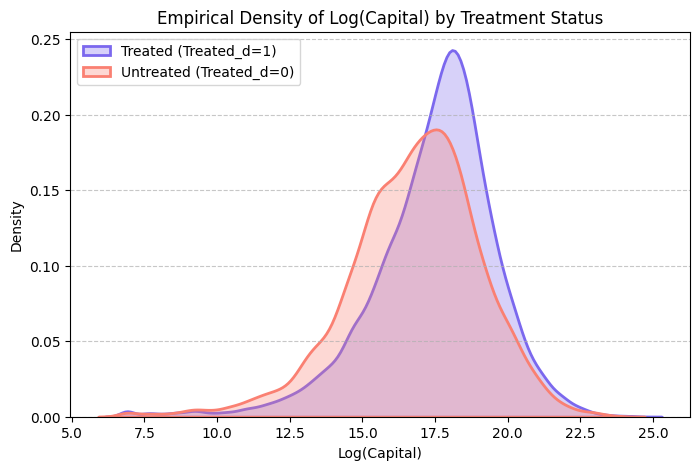

In [4]:
# Define log-transformed capital for treated and untreated groups
log_capital_treated = np.log(balanced_df.loc[balanced_df['Treated_d'] == 1, 'Capital'])
log_capital_untreated = np.log(balanced_df.loc[balanced_df['Treated_d'] == 0, 'Capital'])

# Create the plot
plt.figure(figsize=(8, 5))

# Plot smooth KDE (Kernel Density Estimation) for treated and untreated groups
sns.kdeplot(log_capital_treated, color='mediumslateblue', linewidth=2, label='Treated (Treated_d=1)', fill=True, alpha=0.3)
sns.kdeplot(log_capital_untreated, color='salmon', linewidth=2, label='Untreated (Treated_d=0)', fill=True, alpha=0.3)

# Labels and title
plt.xlabel("Log(Capital)")
plt.ylabel("Density")  # Since area under curve sums to 1
plt.title("Empirical Density of Log(Capital) by Treatment Status")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as an image file
image_path = f"{output_dir}/log_capital_pdf.png"
plt.savefig(image_path, dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()


### Output

For log of Output:

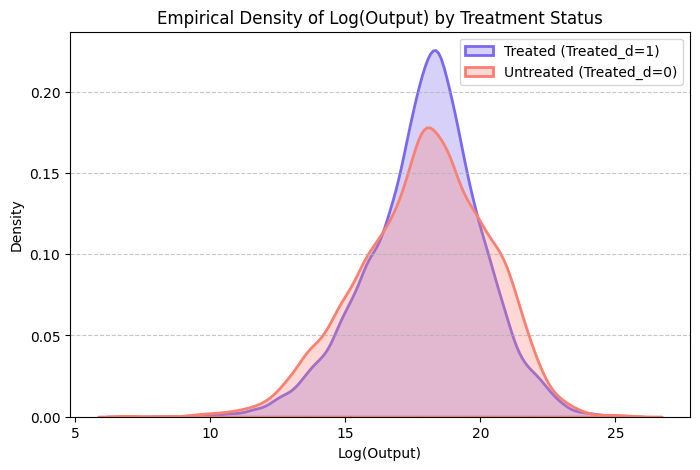

In [5]:
# Define log-transformed output for treated and untreated groups
log_output_treated = np.log(balanced_df.loc[balanced_df['Treated_d'] == 1, 'Output'])
log_output_untreated = np.log(balanced_df.loc[balanced_df['Treated_d'] == 0, 'Output'])

# Create the plot
plt.figure(figsize=(8, 5))

# Plot smooth Kernel Density Estimation (KDE) for treated and untreated groups
sns.kdeplot(log_output_treated, color='mediumslateblue', linewidth=2, label='Treated (Treated_d=1)', fill=True, alpha=0.3)
sns.kdeplot(log_output_untreated, color='salmon', linewidth=2, label='Untreated (Treated_d=0)', fill=True, alpha=0.3)

# Labels and title
plt.xlabel("Log(Output)")
plt.ylabel("Density")  # Since area under curve sums to 1
plt.title("Empirical Density of Log(Output) by Treatment Status")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot as a high-quality image file
image_path = f"{output_dir}/log_output_smooth_pdf.png"
plt.savefig(image_path, dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()

## Time Trends

### Capital

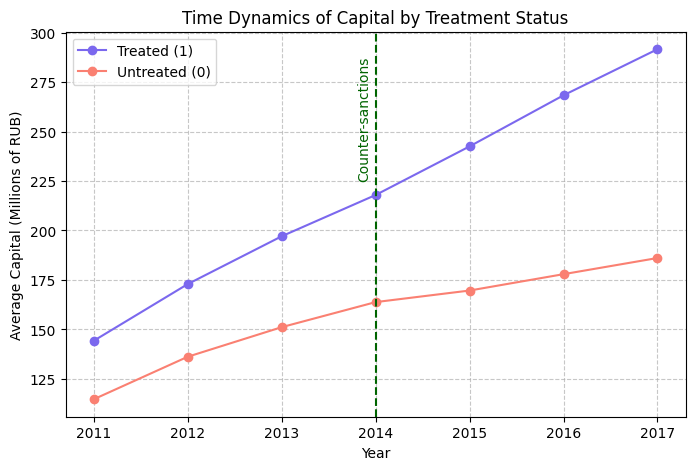

In [6]:
# Group data by year and treatment status, computing mean Capital (converted to millions)
capital_dynamics = balanced_df.groupby(['Year', 'Treated_d'])['Capital'].mean().reset_index()
capital_dynamics['Capital'] /= 1_000_000  # Convert to millions of RUB

# Create the plot
plt.figure(figsize=(8, 5))

# Define color mapping
colors = {1: 'mediumslateblue', 0: 'salmon'}

# Plot treated group
treated_plot, = plt.plot(capital_dynamics[capital_dynamics['Treated_d'] == 1]['Year'],
                         capital_dynamics[capital_dynamics['Treated_d'] == 1]['Capital'],
                         color=colors[1], marker='o', linestyle='-', label='Treated (1)')

# Plot untreated group
untreated_plot, = plt.plot(capital_dynamics[capital_dynamics['Treated_d'] == 0]['Year'],
                           capital_dynamics[capital_dynamics['Treated_d'] == 0]['Capital'],
                           color=colors[0], marker='o', linestyle='-', label='Untreated (0)')

# Add vertical dashed line for 2014 in dark green
plt.axvline(x=2014, color='darkgreen', linestyle='--', linewidth=1.5)

# Add rotated text label to the left of the line
plt.text(2013.8, capital_dynamics['Capital'].max() * 0.88, "Counter-sanctions", 
         rotation=90, verticalalignment='center', fontsize=10, color='darkgreen')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average Capital (Millions of RUB)")
plt.title("Time Dynamics of Capital by Treatment Status")
plt.grid(True, linestyle='--', alpha=0.7)

# Fix legend (remove title)
plt.legend(handles=[treated_plot, untreated_plot])  # No title

# Save the plot
image_path = f"{output_dir}/capital_time_dynamics.png"
plt.savefig(image_path, dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()

### Output

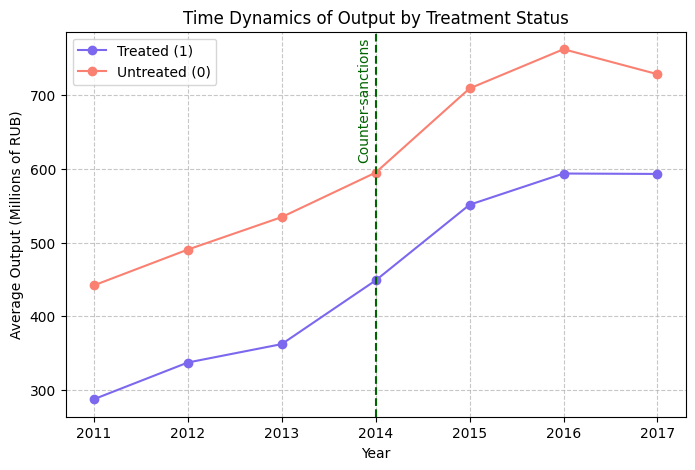

In [7]:
# Group data by year and treatment status, computing mean Output (converted to millions)
output_dynamics = balanced_df.groupby(['Year', 'Treated_d'])['Output'].mean().reset_index()
output_dynamics['Output'] /= 1_000_000  # Convert to millions of RUB

# Create the plot
plt.figure(figsize=(8, 5))

# Define color mapping
colors = {1: 'mediumslateblue', 0: 'salmon'}

# Plot treated group
treated_plot, = plt.plot(output_dynamics[output_dynamics['Treated_d'] == 1]['Year'],
                         output_dynamics[output_dynamics['Treated_d'] == 1]['Output'],
                         color=colors[1], marker='o', linestyle='-', label='Treated (1)')

# Plot untreated group
untreated_plot, = plt.plot(output_dynamics[output_dynamics['Treated_d'] == 0]['Year'],
                           output_dynamics[output_dynamics['Treated_d'] == 0]['Output'],
                           color=colors[0], marker='o', linestyle='-', label='Untreated (0)')

# Add vertical dashed line for 2014 in dark green
plt.axvline(x=2014, color='darkgreen', linestyle='--', linewidth=1.5)

# Add rotated text label to the left of the line
plt.text(2013.8, output_dynamics['Output'].max() * 0.91, "Counter-sanctions", 
         rotation=90, verticalalignment='center', fontsize=10, color='darkgreen')

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average Output (Millions of RUB)")
plt.title("Time Dynamics of Output by Treatment Status")
plt.grid(True, linestyle='--', alpha=0.7)

# Fix legend (remove title)
plt.legend(handles=[treated_plot, untreated_plot])  # No title

# Save the plot
image_path = f"{output_dir}/output_time_dynamics.png"
plt.savefig(image_path, dpi=1000, bbox_inches='tight')

# Show the plot
plt.show()


# Data preparation for QGIS

In [8]:
# Use your existing DataFrame (balanced_df)
df_geo = balanced_df.copy()

# As coordinates were preliminary checked to be the same throughout the years,
# let's keep only the observations for 2014, thus reducing the number of points in 7 times
df_geo = df_geo[(df_geo["Year"] == 2014)]

# Step 1: Split 'coord' column into separate 'Latitude' and 'Longitude'
df_geo[['Latitude', 'Longitude']] = df_geo['coord'].str.split(', ', expand=True).astype(float)

# Step 2: Drop old 'coord' column
df_geo.drop(columns=['coord'], inplace=True)

# Step 3: Save as a CSV file for QGIS (can be imported as point layer)
df_geo_path = "C:/Users/Popov/Documents/Research/Volchkova_thesis/Data/GEO/firms_qgis_points.csv"
df_geo.to_csv(df_geo_path, index=False)

print("Files saved: firms_qgis.csv (for QGIS point layer)")


Files saved: firms_qgis.csv (for QGIS point layer)
